# Introduction

I am building my original pipeline for just the math papers. I know there are two main fields of math: pure math and applied math, so I am going to write the code to see if LDA can dissern the two mathematical fields in the papers.

In [1]:
from pymongo import MongoClient
import pymongo

import re

import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

# gensim
from gensim import corpora, models, similarities, matutils
from gensim.corpora import Dictionary
import gensim

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import plotly as py
import plotly.graph_objs as go
from plotly import offline
py.offline.init_notebook_mode(connected=True)

import colorlover as cl

import math

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from PIL import Image

In [2]:
packages = (('Pymongo',pymongo), ('NLTK',nltk), ('Gensim',gensim),
           ('Regex', re), ('Plotly',py), ('Re',re))

for package in packages:
    print('{0} version: {1}'.format(package[0],package[1].__version__))
    
!Python -V

Pymongo version: 3.2.2
NLTK version: 3.2.5
Gensim version: 3.3.0
Regex version: 2.2.1
Plotly version: 2.2.3
Re version: 2.2.1
Python 3.6.4 :: Anaconda custom (64-bit)


# Get Subset of Data From Mongo

In [3]:
client = MongoClient(port=12345) # this is the port set by the SSH tunnel
db = client.research_papers
db.collection_names()

['cs_papers', 'math_papers', 'stat_papers']

In [4]:
db.math_papers.count()

1409

In [5]:
all_papers = []
current_paper = db.math_papers.find()

for pape in current_paper:    
    article = pape['article']
    if article:
        if len(article) > 5000:
            all_papers.append(pape)
            subset+=1

# Cleaning!!

Gotta get me papes...

![alt text](papes.jpg "Gotta Get Some Papes!")

The word cid it the top word in all classes and seems to stand for random mathematical things, like: fractions, matrices, not equal to, and the box at the end of a proof to signify it is the end of the proof.  Because of this I will take it out of the set.

Also ligatures appear a lot in the translation, the following set was created from the Wikipedea page on ligatures.

In [6]:
ligatures = {'Ꜳ':'AA', 'ꜳ':'aa', 'Æ':'AE', 'æ':'ae', 'Ꜵ':'AO', 'ꜵ':'ao',
            'Ꜷ':'AU', 'ꜷ':'au', 'Ꜹ':'AV', 'ꜹ':'av', 'Ꜻ':'AV', 'ꜻ':'av',
            'Ꜽ':'AY', 'ꜽ':'ay', '🙰':'et', 'ﬀ':'ff', 'ﬃ':'ffi', 'ﬄ':'ffl', 
            'ﬁ':'fi', 'ﬂ':'fl', 'Œ':'OE', 'œ':'oe', 'Ꝏ':'OO', 'ꝏ':'oo', 
            'ﬆ':'st', 'Ꜩ':'TZ', 'ꜩ':'tz', 'ᵫ':'ue', 'Ꝡ':'VY', 'ꝡ':'vy'}

for lig in ligatures:
    re_lig = re.compile(lig)

    for pape in all_papers:
        pape['article'] = re.sub(re_lig, ligatures[lig], pape['article'])

In [7]:
re_cid = re.compile('cid')
et_al_cid = re.compile('et al')

for pape in all_papers:
    pape['article'] = re.sub(re_cid, ' ', pape['article'])
    pape['article'] = re.sub(et_al_cid, '', pape['article'])

## Sanity Check

Do the top words make sense?

In [8]:
all_text_combined = ''
for pape in all_papers:
    all_text_combined += pape['article']
    
all_text_combined = [all_text_combined]

In [9]:
cv = CountVectorizer(stop_words = 'english')
X = cv.fit_transform(all_text_combined)
word_counts = pd.DataFrame(X.toarray().T, index = cv.get_feature_names(), columns = ['Count'])
word_counts = word_counts.sort_values('Count', ascending = False)
word_counts.head(10)

,Count
let,42635
theorem,31219
proof,24840
lemma,22984
set,21334
following,17516
case,17463
function,17220
follows,15253
given,15229


# Count Vectorizer

The set up for LDA

In [10]:
all_text = []
for pape in all_papers:
    all_text.append(pape['article'])

max_df and min_df are the proportion thresholds

0.795 knocks out the common words used by both topics.

In [34]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words = 'english', max_df = 0.795, min_df = 0.05)
counts = count_vectorizer.fit(all_text)
counts = count_vectorizer.transform(all_text).transpose()

In [35]:
word_counts = pd.DataFrame(counts.toarray(), index = count_vectorizer.get_feature_names())
word_counts.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297
aa,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ab,0,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abelian,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,0


In [36]:
corpus = matutils.Sparse2Corpus(counts)

id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
len(id2word)

4140

# LDA
The good stuff...

In [37]:
num_topics = 2

In [38]:
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=35, minimum_probability = 0)

2018-04-11 12:12:49,905 : INFO : using symmetric alpha at 0.5
2018-04-11 12:12:49,907 : INFO : using symmetric eta at 0.5
2018-04-11 12:12:49,908 : INFO : using serial LDA version on this node
2018-04-11 12:12:49,953 : INFO : running online (multi-pass) LDA training, 2 topics, 35 passes over the supplied corpus of 1298 documents, updating model once every 1298 documents, evaluating perplexity every 1298 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-11 12:13:07,519 : INFO : -8.699 per-word bound, 415.7 perplexity estimate based on a held-out corpus of 1298 documents with 3143804 words
2018-04-11 12:13:07,520 : INFO : PROGRESS: pass 0, at document #1298/1298
2018-04-11 12:13:10,912 : INFO : topic #0 (0.500): 0.005*"space" + 0.005*"proposition" + 0.003*"exists" + 0.003*"matrix" + 0.003*"math" + 0.003*"equation" + 0.003*"point" + 0.003*"problem" + 0.003*"definition" + 0.003*"time"
2018-04-11 12:13:10,912 : INFO : topic #1 (0.500): 0.004*"proposition" + 0.004*"po

2018-04-11 12:16:38,106 : INFO : topic #1 (0.500): 0.006*"proposition" + 0.005*"space" + 0.005*"group" + 0.005*"algebra" + 0.004*"definition" + 0.004*"finite" + 0.004*"point" + 0.004*"map" + 0.004*"math" + 0.004*"exists"
2018-04-11 12:16:38,107 : INFO : topic diff=0.016709, rho=0.288675
2018-04-11 12:16:55,268 : INFO : -7.607 per-word bound, 194.9 perplexity estimate based on a held-out corpus of 1298 documents with 3143804 words
2018-04-11 12:16:55,269 : INFO : PROGRESS: pass 11, at document #1298/1298
2018-04-11 12:16:58,463 : INFO : topic #0 (0.500): 0.005*"solution" + 0.005*"problem" + 0.004*"equation" + 0.004*"time" + 0.004*"log" + 0.004*"equations" + 0.003*"rn" + 0.003*"random" + 0.003*"dx" + 0.003*"functions"
2018-04-11 12:16:58,464 : INFO : topic #1 (0.500): 0.006*"proposition" + 0.005*"space" + 0.005*"group" + 0.005*"algebra" + 0.004*"definition" + 0.004*"finite" + 0.004*"point" + 0.004*"map" + 0.004*"math" + 0.004*"exists"
2018-04-11 12:16:58,465 : INFO : topic diff=0.014856,

2018-04-11 12:20:25,329 : INFO : topic diff=0.006489, rho=0.208514
2018-04-11 12:20:42,251 : INFO : -7.605 per-word bound, 194.6 perplexity estimate based on a held-out corpus of 1298 documents with 3143804 words
2018-04-11 12:20:42,252 : INFO : PROGRESS: pass 22, at document #1298/1298
2018-04-11 12:20:45,353 : INFO : topic #0 (0.500): 0.005*"solution" + 0.005*"problem" + 0.005*"equation" + 0.004*"log" + 0.004*"time" + 0.004*"random" + 0.004*"equations" + 0.004*"rn" + 0.003*"dx" + 0.003*"probability"
2018-04-11 12:20:45,354 : INFO : topic #1 (0.500): 0.006*"proposition" + 0.006*"space" + 0.005*"group" + 0.005*"algebra" + 0.005*"definition" + 0.004*"finite" + 0.004*"point" + 0.004*"map" + 0.004*"math" + 0.004*"exists"
2018-04-11 12:20:45,355 : INFO : topic diff=0.006067, rho=0.204124
2018-04-11 12:21:02,399 : INFO : -7.605 per-word bound, 194.6 perplexity estimate based on a held-out corpus of 1298 documents with 3143804 words
2018-04-11 12:21:02,400 : INFO : PROGRESS: pass 23, at docu

2018-04-11 12:24:27,962 : INFO : PROGRESS: pass 33, at document #1298/1298
2018-04-11 12:24:31,127 : INFO : topic #0 (0.500): 0.005*"solution" + 0.005*"problem" + 0.005*"equation" + 0.005*"log" + 0.004*"time" + 0.004*"random" + 0.004*"equations" + 0.004*"rn" + 0.004*"probability" + 0.003*"dx"
2018-04-11 12:24:31,127 : INFO : topic #1 (0.500): 0.006*"proposition" + 0.006*"space" + 0.005*"group" + 0.005*"algebra" + 0.005*"definition" + 0.004*"finite" + 0.004*"point" + 0.004*"map" + 0.004*"math" + 0.004*"exists"
2018-04-11 12:24:31,128 : INFO : topic diff=0.003138, rho=0.169031
2018-04-11 12:24:48,223 : INFO : -7.604 per-word bound, 194.6 perplexity estimate based on a held-out corpus of 1298 documents with 3143804 words
2018-04-11 12:24:48,224 : INFO : PROGRESS: pass 34, at document #1298/1298
2018-04-11 12:24:51,371 : INFO : topic #0 (0.500): 0.005*"solution" + 0.005*"problem" + 0.005*"log" + 0.005*"equation" + 0.004*"time" + 0.004*"random" + 0.004*"equations" + 0.004*"rn" + 0.004*"prob

In [39]:
lda.print_topics()

2018-04-11 12:26:02,924 : INFO : topic #0 (0.500): 0.005*"solution" + 0.005*"problem" + 0.005*"log" + 0.005*"equation" + 0.004*"time" + 0.004*"random" + 0.004*"equations" + 0.004*"rn" + 0.004*"probability" + 0.003*"dx"
2018-04-11 12:26:02,925 : INFO : topic #1 (0.500): 0.006*"proposition" + 0.006*"space" + 0.005*"group" + 0.005*"algebra" + 0.005*"definition" + 0.004*"finite" + 0.004*"point" + 0.004*"map" + 0.004*"math" + 0.004*"exists"


[(0,
  '0.005*"solution" + 0.005*"problem" + 0.005*"log" + 0.005*"equation" + 0.004*"time" + 0.004*"random" + 0.004*"equations" + 0.004*"rn" + 0.004*"probability" + 0.003*"dx"'),
 (1,
  '0.006*"proposition" + 0.006*"space" + 0.005*"group" + 0.005*"algebra" + 0.005*"definition" + 0.004*"finite" + 0.004*"point" + 0.004*"map" + 0.004*"math" + 0.004*"exists"')]

## Pickle!!!!

In [40]:
with open('Math_LDA.pkl','wb') as pickle_out:
    pickle.dump(lda, pickle_out)

# with open('Math_LDA.pkl','rb') as pickle_in:
#     lda = pickle.load(pickle_in,)

# PCA

Not needed for dimension reduction, it makes for a good quick plot though. 

In [41]:
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
lda_docs[0:5]

[[(0, 0.9330436), (1, 0.06695638)],
 [(0, 0.84168863), (1, 0.1583113)],
 [(0, 0.00031328475), (1, 0.99968666)],
 [(0, 0.75607747), (1, 0.24392252)],
 [(0, 0.9547376), (1, 0.045262355)]]

In [42]:
lda_X = np.array([])

count = 0
for doc in lda_corpus:
    for prob in doc:
        lda_X = np.append(lda_X,prob[1])

lda_X = lda_X.reshape(-1,num_topics)
lda_X.shape

(1298, 2)

In [43]:
pca = PCA(n_components=2) # Uses SVD
pca.fit(lda_X)
pca_lda_X = pca.transform(lda_X)

# Logical Grouping of Subjects

To create the plots, I will group each of the subjects for a given paper.  If there is more that one subject, I will assume the aurthor classified the first subject as the most representative of the paper and take the first one.

For each paper the subject and grouping will be added to the first two columns of the array containing the translated PCA coordinates (pca_lda_X).  Therefore each document will have a row in the PCA coordinates array that looks as follows: grouping, subject, coordinate 1, coordinate 2, ...

## Subject Groupings

In [48]:
def Get_Subject_to_Group(group_to_subj):
    '''Reverses the dictionary for the group to subject mapping, returning 
        a dictionary mapping the subjects to the groups.'''
    subj_to_group = {}

    for group in group_to_subj.keys():

        for subj in group_to_subj[group]:

            subj_to_group[subj] = group
            
    return subj_to_group

The 32 ArXiv.org math topics grouped by my own knowledge in the subject.

In [49]:
group_to_subj = {'pure': ['ac', 'ag', 'at', 'co', 'ct', 'cv', 'dg', 'fa', 'gn', 'gr', 'gt', 'kt', 'mg', 'nt', 'oa', 'qa', 'ra', 'rt', 'sg'],
              'applied' : ['ap', 'ca', 'ds', 'it', 'mp', 'na', 'oc', 'sp'],
               'stats': ['pr', 'st'],
                'odd balls': ['gm', 'ho', 'lo']}

subj_to_group = Get_Subject_to_Group(group_to_subj)

## All Paper's Main Subject

In [50]:
def get_all_papers_subjects(all_papers, pca_lda_X):
    '''Gets the main subject for each of the papers.'''
    subjects = np.array([])

    for pape in all_papers:

        subj = pape['subject']
        subj = subj[0]

        # almost all subjects are given as math.XX
        if subj == 'math-ph':
            subj = 'mp'
        else:
            subj = subj.split('.')
            subj = subj[1]

        subjects = np.append(subjects, subj)
    
    subjects = subjects.reshape(-1,1)


    pca_lda_X = np.append(subjects, pca_lda_X, axis = 1)
    
    return pca_lda_X

In [51]:
def get_all_papers_groupings(pca_lda_X):
    '''
        Gets the grouping for each of the papers using the subject. If a 
        subject was missed in the grouping process.
    '''
    
    groupings = np.array([])
    
    for subj in pca_lda_X[:,0]:

        group = subj_to_group[subj]

        groupings = np.append(groupings, group)
            
    groupings = groupings.reshape(-1,1)
    
    pca_lda_X = np.append(groupings, pca_lda_X, axis = 1)
    
    return pca_lda_X

In [52]:
pca_lda_X = get_all_papers_subjects(all_papers, pca_lda_X)
pca_lda_X = get_all_papers_groupings(pca_lda_X)

# Plots of Topics

Plot of the PCA coordinates of the topic distribution for each paper.

In [53]:
def pca_plot(title):
    '''
        Outputs the plot of the first two inertias found using the PCA method.
        Each paper is colored by the groupings, which I labeled.
    '''
    groups = list(group_to_subj.keys())

    colors = cl.scales[str(len(groups))]['qual']['Set1']

    data = []
    for index, group in enumerate(groups):

        locs = (pca_lda_X[:,0] == group)

        points = go.Scatter(
            x = pca_lda_X[locs,2],
            y = pca_lda_X[locs,3],
            mode = 'markers',
            name = group,
            marker = dict(
                opacity = 0.5,
                color = colors[index],
                size = 15
            )
        )

        data.append(points)

    layout = go.Layout(
        autosize=False,
        width=800,
        height=800,
        title=title,
        titlefont=dict(
            size=25
        ),
        xaxis=dict(
            showgrid=False,
            zeroline=True,
            showticklabels=False
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=True,
            showticklabels=False
        )
    )

    fig = go.Figure(data=data, layout=layout)

    py.offline.iplot(fig)

In [54]:
pca_plot('Mathematical Papers')

# Scaling Subjects

For each of the 32 subjects given in the ArXiv mathematics section, I am finding the average distirubtion among the two topics.  The median is also an appropriate measure.

In [60]:
def pt_est_by_subject(lda_X):
    '''
        Given the list of subjects and list of the pca lda 
        distributions, the funciton returns an array containing 
        the subject and the median pca lda distribution point.
    '''
    
    subjects = set(lda_X[:,1])
    
    med_lda_X = np.array([])

    for subj in subjects:
        locs = (lda_X[:,1] == subj)
        
        med_coords = np.median(lda_X[locs,2:].astype('float'), axis = 0)
        
        group = subj_to_group[subj]
        
        med_X = np.append(np.array([group, subj]), med_coords)
        
        med_lda_X = np.append(med_lda_X, med_X)
    
    med_lda_X = med_lda_X.reshape(len(subjects),-1)
    
    return med_lda_X

In [61]:
def min_point_dists(new_point, all_points, x_spread, y_spread):
    '''
        Calculates the distance between each of the points. Returns a the minimum
        distance between that point and the rest of the points.
    '''

    all_points = all_points.reshape(-1,2)
    X_dist = np.square(new_point[0]-all_points[:,0])
    Y_dist = np.square(new_point[1]-all_points[:,1])

    pt_dist = np.sqrt(x_spread*X_dist+y_spread*Y_dist)
    
    return pt_dist.min()


An attempt to map the subject names nicely on the plot.  I later switched to a D3 plot with hover text.

In [62]:
def plotly_annotations(pt_est_lda_X, x_spread, y_spread):
    '''
        Finds the annotation location based on text distance. As it turns out this
        is a pain of a problem!
    '''
    
    all_points = pt_est_lda_X[:,2:].astype('float')
    
    annotations = []
    avg_spread = (y_spread + x_spread)/2
    
    for index, point in enumerate(pt_est_lda_X):
        angle = math.pi/2
        r_x = x_spread/20
        r_y = y_spread/15
        tries = 0

        base_point = point[2:4].astype('float')
        
        new_point = base_point.copy()
        
        min_dist = min_point_dists(new_point, all_points, x_spread, y_spread)
        while (min_dist < avg_spread/15) | (abs(new_point[0]) < x_spread/30) \
                        | (abs(new_point[1]) < y_spread/40):

            tries+=1
            
            new_point[0] = r_x*math.cos(angle)+base_point[0]
            new_point[1] = r_y*math.sin(angle)+base_point[1]*0
    
            min_dist = min_point_dists(new_point, all_points, x_spread, y_spread)
            
            angle += math.pi/12
                
            if tries % 24 == 0:
                r_x += 0.5*r_x
                r_y += 0.5*r_y

        all_points = np.append(all_points, new_point)
        
        temp = dict(
                x = point[2],
                y = point[3],
                xref = 'x',
                yref = 'y',
                axref = 'x',
                ayref = 'y',
                text = point[1],
                font=dict(
                    size=18,
                    ),
                showarrow = True,
                arrowhead = 0,
                ax = new_point[0],
                ay = new_point[1]
            )
        
        annotations.append(temp)
        
    return annotations

In [105]:
def pt_est_subject_plot(lda_X, title):
    '''
        Outputs the plot of the median distribution point given by 
        lda for each subject. Each subject is colored by the groupings, 
        which I labeled.
    '''
    
    pt_est_lda_X = pt_est_by_subject(lda_X)
    
    groups = list(group_to_subj.keys())

    colors = cl.scales[str(len(groups))]['qual']['Set1']
    
    data = []
    for index, group in enumerate(groups):

        locs = (pt_est_lda_X[:,0] == group)
                
        points = go.Scatter(
            x = pt_est_lda_X[locs,2],
            y = pt_est_lda_X[locs,3],
            mode = 'markers',
            name = group,
            marker = dict(
                color = colors[index],
                size = 15
            )
        )

        data.append(points)
    
    x_max = pt_est_lda_X[:,2].astype('float').max()
    x_min = pt_est_lda_X[:,2].astype('float').min()
    x_spread = x_max-x_min
    x_range = [x_min-x_spread/10, x_max+x_spread/10]

    y_max = pt_est_lda_X[:,3].astype('float').max()
    y_min = pt_est_lda_X[:,3].astype('float').min()
    y_spread = y_max-y_min
    
    if y_spread < 1:
        y_spread = 0.5
        
    y_range = [y_min-y_spread, y_max+y_spread]

    layout = go.Layout(
        autosize = False,
        width = 800,
        height = 400,
        title = title,
        titlefont = dict(
            size = 25
        ),
        xaxis = dict(
            range = x_range,
            showgrid = False,
            zeroline = True,
            showticklabels = False
        ),
        yaxis = dict(
            range = y_range,
            showgrid = False,
            zeroline = True,
            showticklabels = False
        ),
        annotations = plotly_annotations(pt_est_lda_X, x_spread, y_spread)
    )

    fig = go.Figure(data=data, layout=layout)

    py.offline.iplot(fig)

In [106]:
pt_est_subject_plot(pca_lda_X, 'Median Subject Plot')

# Topics Word Cloud

Thank you [Tiffany Moeller](https://github.com/TifMoe)

Topic 1: rgb(143, 83, 159)

Topic 2: rgb(231, 119, 21)


In [138]:
def random_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    r,g,b = 248, 186, 0
    
    prop = (1-0.5)*np.random.random()+0.5
    r = str(int(prop*r))
    g = str(int(prop*g))
    b = str(int(prop*b))
    return "rgb(" + r + "," + g + ", " + b + ")" 

In [139]:
def generate_cloud(lda):

    cloud_mask = np.array(Image.open('word_cloud_mask.jpg'))
    
    colors = cl.scales['3']['qual']['Set1']

    for t_index in range(lda.num_topics):
        wordcloud = WordCloud(background_color="white",
                              max_words=100,
                              height=900,
                              width=1200,
                              relative_scaling=0,
                              color_func = random_color_func,
                              mask=cloud_mask
                             )
        
        wordcloud.fit_words(lda.show_topic(t_index, 50))
        
        plt.figure(figsize=(15,12))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

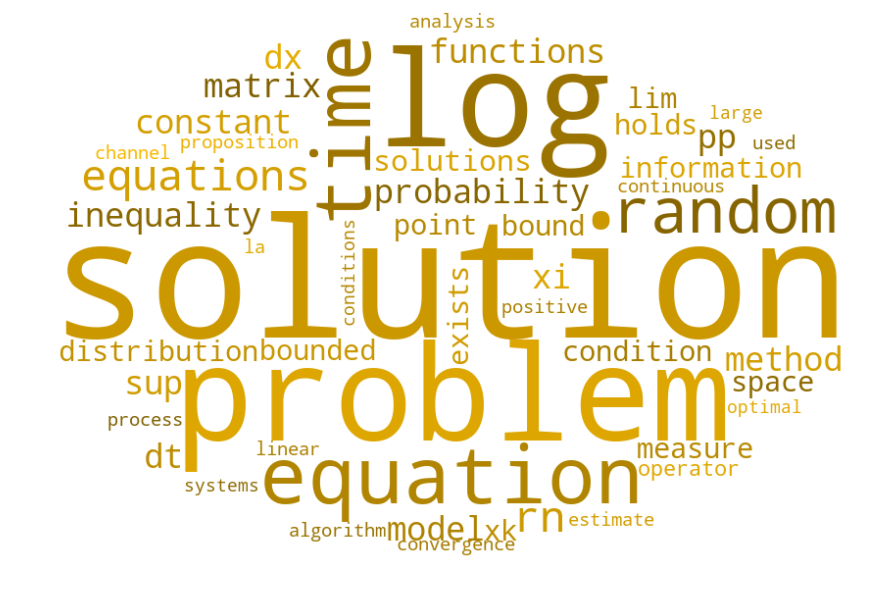

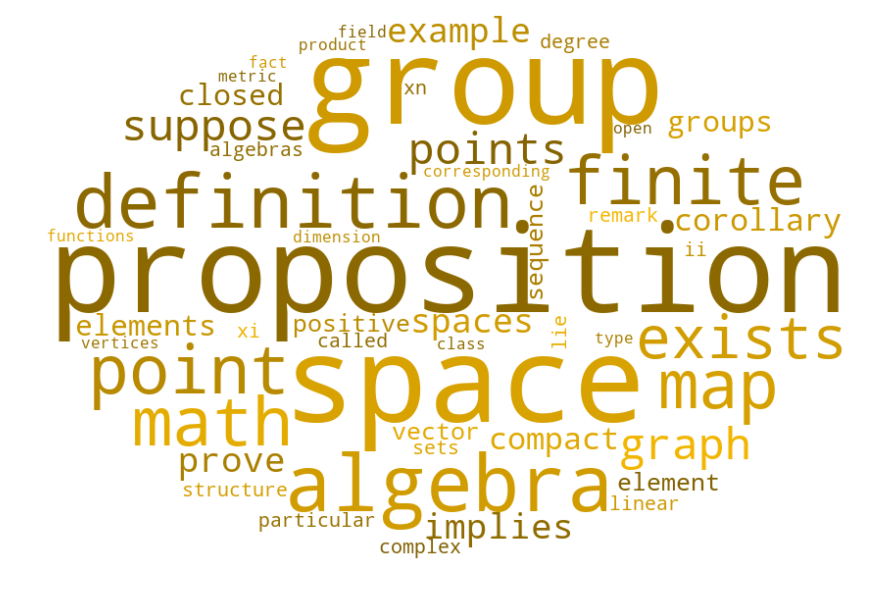

In [140]:
generate_cloud(lda)

# D3 Set Up

The D3 plot shows the distribution of the 32 ArXiv math subjects among the two topics found.  For the D3 plot, I needed to have the data in a certian format.  This chunck of code will put it in the format for me, so I will just need to copy and paste it into D3.

In [86]:
def med_prop_by_subject(lda_X):
    '''
        Given the list of subjects and list of distribution points, 
        the funciton returns an array containing the subject
        and the median proportion of the LDA topic distribution.
        The median is taken over the mean because the underlying
        distribution is unknown and the median is unaffected by
        outliers.
    '''
    
    lda_X = get_all_papers_subjects(all_papers, lda_X)
    
    subjects = set(lda_X[:,0])
    
    med_lda_X = np.array([])

    for subj in subjects:
        locs = (lda_X[:,0] == subj)
        
        med_coords = np.median(lda_X[locs,1:].astype('float'),axis = 0)
        
        med_coords = np.round(med_coords*100,0)
        
        group = subj_to_group[subj]
        
        med_X = np.append(np.array([group, subj]), med_coords)
        
        med_lda_X = np.append(med_lda_X, med_X)
    
    med_lda_X = med_lda_X.reshape(len(subjects),-1)
    
    return med_lda_X

In [130]:
def d3_format(med_lda,topic):
    '''
        Takes the average lda for each subject and formats it to the 
        D3 code for the ternary plot.  Each subject will have the 
        output:
        {topic_1: ##, topic_2: ##, label: 'Subject'}
    '''
    
    subject_names = pd.read_csv('Subject_Names.csv')
    subject_names = subject_names.loc[subject_names['Subject'] == 'math']
    
    d3_input = []
    current_points = np.array([])
    
    for row in med_lda:
        subj = row[1]
        
        label = subject_names.loc[subject_names['abbrev'] == subj, 'Topic']
        label = label.get_values()[0]
        
        if subj_to_group[subj] == topic:
            # numpy and I aren't friends right now
            topic1_percent = row[2].astype('float').astype('int')
            topic2_percent = row[3].astype('float').astype('int')
            
            accounted_for = False
            for d3_row in d3_input:
                if d3_row['atopic_1'] == topic1_percent:
                    d3_row['label'] = d3_row['label'] + ',</br>' + label
                    accounted_for = True
                    break
                    
            if not accounted_for:
                # the a in front of topic puts it in the order I want
                d3_row = {'atopic_1': topic1_percent, \
                          'atopic_2': topic2_percent, \
                          'label': label}
                d3_input.append(d3_row)
    
    return d3_input

In [131]:
def fix_quotes(string):
    '''
        The original output of the dictionary in d3_format will look
        like 
                {'atopic_1': ##, 'atopic_2': ##, 'label': 'Subject'}.
        This function will removes the quotes from around atopic_1,
        atopic_2, and label as well as change atopic to topic.
    '''
    
    quotes_1 = re.compile(r'\'atopic_')
    string = re.sub(quotes_1, 'topic_', string)

    quotes_2 = re.compile(r'\':')
    string = re.sub(quotes_2, ':', string)
    
    quotes_3 = re.compile(r'\'label')
    string = re.sub(quotes_3, 'label', string)

    return string

In [132]:
def get_d3_output(lda_X, topic, d3_var_name):
    ''' Gets the output for the d3 ternary plot.'''
    med_lda = med_prop_by_subject(lda_X)
    
    d3_out = d3_format(med_lda, topic)
    
    d3_output = []
    
    for index, row in enumerate(d3_out):
        row = fix_quotes(str(row))
        if index == len(d3_out)-1:
            d3_output.append(row)
        else:
            d3_output.append(row+',\n')
        
    print('var '+ d3_var_name + ' = [' + ' '.join(d3_output) + '];\n')

In [133]:
get_d3_output(lda_X,'pure','pure_data')
get_d3_output(lda_X,'applied','applied_data')
get_d3_output(lda_X,'stats','stats_data')
get_d3_output(lda_X,'odd balls','odd_ball_data')

var pure_data = [{topic_1: 0, topic_2: 100, label: 'Category Theory,</br>Quantum Algebra,</br>K-Theory and Homology,</br>Commutative Algebra,</br>Representation Theory,</br>Group Theory,</br>Rings and Algebras'},
 {topic_1: 1, topic_2: 99, label: 'Operator Algebras,</br>Algebraic Geometry,</br>Geometric Topology'},
 {topic_1: 4, topic_2: 96, label: 'General Topology'},
 {topic_1: 48, topic_2: 52, label: 'Complex Variables'},
 {topic_1: 20, topic_2: 80, label: 'Number Theory'},
 {topic_1: 13, topic_2: 87, label: 'Algebraic Topology'},
 {topic_1: 30, topic_2: 70, label: 'Differential Geometry'},
 {topic_1: 29, topic_2: 71, label: 'Metric Geometry'},
 {topic_1: 39, topic_2: 61, label: 'Functional Analysis'},
 {topic_1: 10, topic_2: 90, label: 'Combinatorics'},
 {topic_1: 3, topic_2: 97, label: 'Symplectic Geometry'}];

var applied_data = [{topic_1: 74, topic_2: 26, label: 'Mathematical Physics'},
 {topic_1: 89, topic_2: 11, label: 'Analysis of PDEs'},
 {topic_1: 39, topic_2: 61, label: 'D